In [1]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 8.1 MB/s 


In [2]:
import numpy as np
import mahotas
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
!wget "https://www.crcv.ucf.edu/data/ucf_sports_actions.zip" --no-check-certificate
!unzip "ucf_sports_actions.zip"

In [5]:
import tensorflow as tf
import tensorflow.keras as keras

from keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Dense, Activation, Dropout, Bidirectional
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam

import os
from os import listdir

from keras.applications.vgg19 import VGG19

In [6]:
SIZE = 224

VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

for layer in VGG_model.layers:
    layer.trainable=False

80150528/80134624 [==============================] - 0s 0us/step


In [15]:
def process_video(fname):
    """
        Uses Hu and Zernike moments

    """

    parts = fname.split(os.sep)
    label = parts[-2]

    colour_features = []

    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()

    count = 0
    while success:
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(img2, 75, 200, cv2.THRESH_BINARY)[1]
        F = np.append(mahotas.features.zernike_moments(thresh, 200), cv2.HuMoments(cv2.moments(img2)).flatten())
        #print(F)
        colour_features.append(F)
        success, img = vidcap.read()
        count += 1
    
    print(f'Read {count} frames from {fname}')

    if (count < 8):
        print(f'Only {count} frames. Skipping video')
        return None, None

    vidcap.release()
        
    best_i = 0
    best_sc = -1

    """
    for i in range(2,21):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(colour_features)
        sc = silhouette_score(colour_features, kmeans.labels_)
        if(sc > best_sc):
            best_i = i
            best_sc = sc
        # print(i, silhouette_score(colour_features, kmeans.labels_))

    # print(f'Best silhouette score was {best_sc} for k value of {best_i}')
    """

    best_i = 5

    kmeans = KMeans(n_clusters=best_i, random_state=0).fit(colour_features)
    cents = kmeans.cluster_centers_

    # print(len(colour_features), len(kmeans.labels_))

    min_dict = {}
    min_frame= {}
    for i in range(len(kmeans.labels_)):
        t = np.linalg.norm(colour_features[i]-cents[kmeans.labels_[i]])
        if kmeans.labels_[i] not in min_dict:
            min_dict[kmeans.labels_[i]] = t
            min_frame[kmeans.labels_[i]] = i
        else:
            if(t < min_dict[kmeans.labels_[i]]):
                min_dict[kmeans.labels_[i]] = t
                min_frame[kmeans.labels_[i]] = i

    # print(min_frame)

    key_frames = list(min_frame.values())

    count = 0

    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()

    img_arr = []

    while success:
        if count in key_frames:
            #print(f'{count} in key frame')
            img = cv2.resize(img, (SIZE,SIZE))
            img_arr.append(img)
        success, img = vidcap.read()
        count += 1
    vidcap.release()

    f = VGG_model.predict(np.array(img_arr))
    f = f.reshape(f.shape[0], -1)

    return f , label


In [ ]:
img_arr = []
labels = []

for root, dirs, files in os.walk("/content/ucf_sports_actions", topdown=False):
    for name in files:
        #print(os.path.join(root, name))
        if('avi' in name):
            imgs, label = process_video(os.path.join(root, name))
            if (type(label) == type(None)):
              continue
            img_arr.append(imgs)
            labels.append(label)

In [23]:
from sklearn import preprocessing
import keras.utils
from tensorflow.keras.utils import to_categorical

labels_encoded = preprocessing.LabelEncoder().fit_transform(labels)
train_labels=to_categorical(labels_encoded).astype(int)

In [25]:
X_train = np.array(img_arr)
X_train.shape

(134, 5, 25088)

In [30]:
model=Sequential()
model.add(Bidirectional(LSTM(units=512,return_sequences=True), input_shape=(X_train.shape[1], 25088)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_labels.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

In [31]:
train_labels.shape

(134, 22)

In [32]:
train_hist = model.fit(X_train, train_labels, batch_size=32, epochs=50)

Epoch 1/50
5/5 [==============================] - 11s 183ms/step - loss: 3.0824 - categorical_accuracy: 0.0672
Epoch 2/50
5/5 [==============================] - 1s 183ms/step - loss: 3.0035 - categorical_accuracy: 0.0970
Epoch 3/50
5/5 [==============================] - 1s 186ms/step - loss: 2.8679 - categorical_accuracy: 0.1791
Epoch 4/50
5/5 [==============================] - 1s 183ms/step - loss: 2.7486 - categorical_accuracy: 0.1716
Epoch 5/50
5/5 [==============================] - 1s 197ms/step - loss: 2.6133 - categorical_accuracy: 0.2164
Epoch 6/50
5/5 [==============================] - 1s 188ms/step - loss: 2.4612 - categorical_accuracy: 0.3060
Epoch 7/50
5/5 [==============================] - 1s 194ms/step - loss: 2.3654 - categorical_accuracy: 0.3358
Epoch 8/50
5/5 [==============================] - 1s 185ms/step - loss: 2.2234 - categorical_accuracy: 0.3582
Epoch 9/50
5/5 [==============================] - 1s 185ms/step - loss: 2.0374 - categorical_accuracy: 0.4701
Epoch 10/

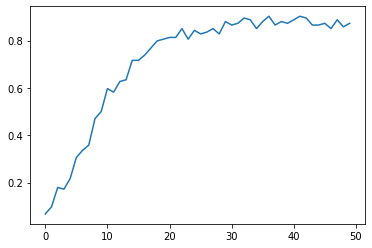

In [33]:
import matplotlib.pyplot as plt

plt.plot(train_hist.history['categorical_accuracy'])

In [43]:
model2=Sequential()
model2.add(LSTM(units=512, return_sequences=True, input_shape=(X_train.shape[1], 25088)))
model2.add(LSTM(64))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(train_labels.shape[1]))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

In [44]:
train_hist2 = model2.fit(X_train, train_labels, batch_size=32, epochs=100)

Epoch 1/100
5/5 [==============================] - 7s 101ms/step - loss: 3.0912 - categorical_accuracy: 0.0672
Epoch 2/100
5/5 [==============================] - 0s 99ms/step - loss: 2.8628 - categorical_accuracy: 0.0821
Epoch 3/100
5/5 [==============================] - 1s 109ms/step - loss: 2.7041 - categorical_accuracy: 0.1493
Epoch 4/100
5/5 [==============================] - 0s 98ms/step - loss: 2.5221 - categorical_accuracy: 0.2463
Epoch 5/100
5/5 [==============================] - 1s 102ms/step - loss: 2.2977 - categorical_accuracy: 0.3134
Epoch 6/100
5/5 [==============================] - 0s 99ms/step - loss: 2.0298 - categorical_accuracy: 0.5000
Epoch 7/100
5/5 [==============================] - 0s 96ms/step - loss: 1.6860 - categorical_accuracy: 0.6269
Epoch 8/100
5/5 [==============================] - 0s 99ms/step - loss: 1.3996 - categorical_accuracy: 0.6940
Epoch 9/100
5/5 [==============================] - 0s 100ms/step - loss: 1.1355 - categorical_accuracy: 0.7164
Epoch 

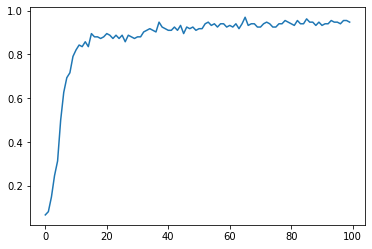

In [45]:
plt.plot(train_hist2.history['categorical_accuracy'])

In [47]:
final_acc = train_hist2.history['categorical_accuracy'][-1]
print(f'Final value of accuracy: {final_acc}')

Final value of accuracy: 0.9477611780166626
